<a href="https://colab.research.google.com/github/N3wBaz/forest_project/blob/main/9_evaluation_selection(competition)/Forest.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')


Mounted at /content/gdrive/


In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import StratifiedKFold

In [22]:
SEED = 42

In [38]:
data = pd.read_csv("/content/gdrive/MyDrive/RS_school_course/9_capstone_project/ml_project/train.csv", index_col=0)

In [39]:
target = data['Cover_Type']
features = data.drop(columns=['Cover_Type'])


In [25]:
# тестовые данные
test = pd.read_csv("/content/gdrive/MyDrive/RS_school_course/9_capstone_project/KaggleCompetion/test.csv.zip")

In [26]:
for items in features.columns:
    if features[items].std() == 0:
        print(items)
        features.drop(items,axis = 1,inplace = True)

Soil_Type7
Soil_Type15


In [27]:
test.drop("Soil_Type7",axis = 1,inplace = True)
test.drop("Soil_Type15",axis = 1,inplace  =True)

In [28]:
test_id = test['Id']
test = test.drop(columns=["Id"])
test.head()


,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type31,Soil_Type32,Soil_Type33,Soil_Type34,Soil_Type35,Soil_Type36,Soil_Type37,Soil_Type38,Soil_Type39,Soil_Type40
0,2680,354,14,0,0,2684,196,214,156,6645,...,0,0,0,0,0,0,0,0,0,0
1,2683,0,13,0,0,2654,201,216,152,6675,...,0,0,0,0,0,0,0,0,0,0
2,2713,16,15,0,0,2980,206,208,137,6344,...,0,0,0,0,0,0,0,0,0,0
3,2709,24,17,0,0,2950,208,201,125,6374,...,0,0,0,0,0,0,0,0,0,0
4,2706,29,19,0,0,2920,210,195,115,6404,...,0,0,0,0,0,0,0,0,0,0


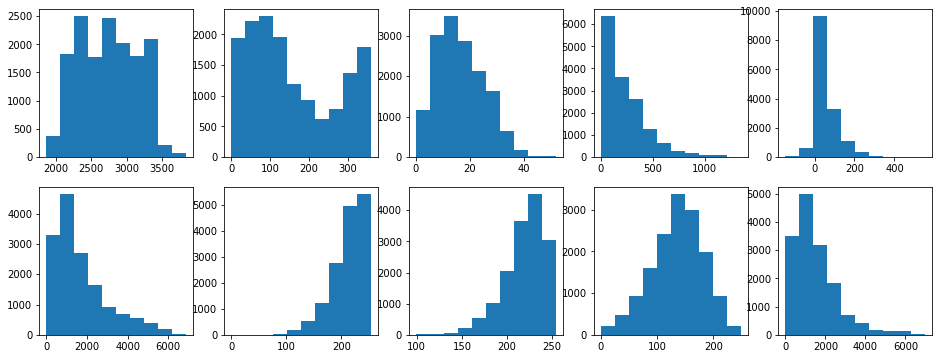

In [42]:
plt.figure(figsize=(16,6))
for i in range(1, 11):
    plt.subplot(2, 5, i)
    plt.hist(data[data.columns[i-1]])

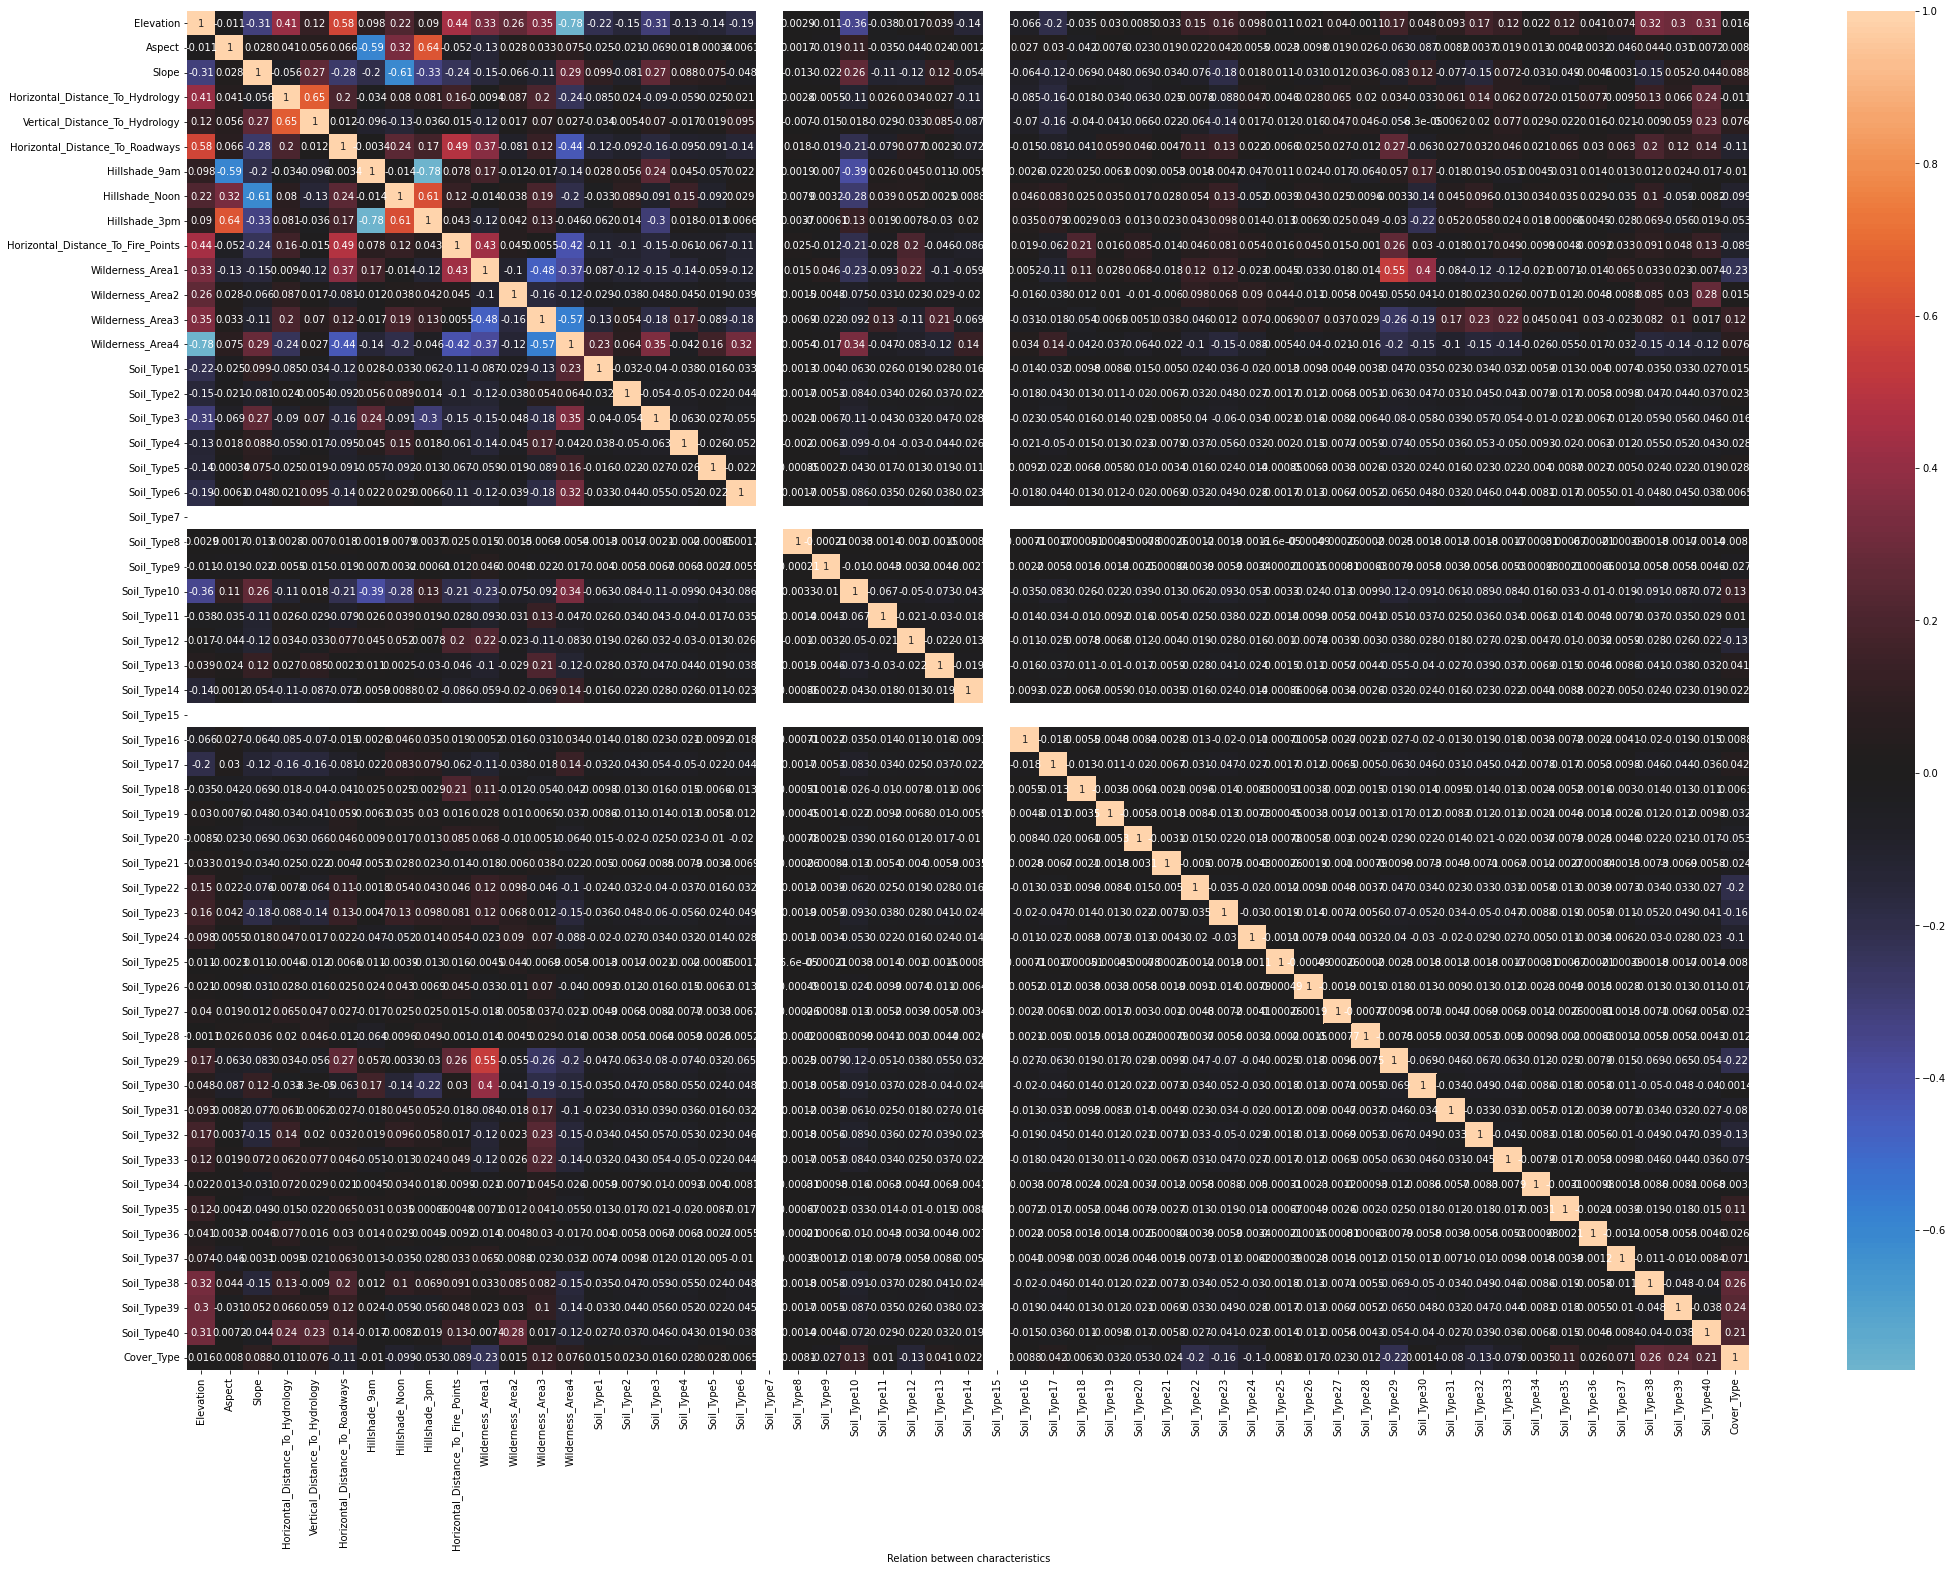

In [47]:
data_corr=data.corr()

plt.figure(figsize=(35,25))
sns.heatmap(data=data_corr, cmap='icefire', center=0, annot=True)
plt.xlabel("Relation between characteristics")
plt.show()

In [ ]:
# видим те самые удаленные признаки №7 и №15 и то что основные корреляции в верхнем левом квадрате.

In [29]:
# мучаем признаки

features["hyd_distance"]=np.sqrt(features["Vertical_Distance_To_Hydrology"]**2 + features["Horizontal_Distance_To_Hydrology"]**2)
test["hyd_distance"]=np.sqrt(test["Vertical_Distance_To_Hydrology"]**2 + test["Horizontal_Distance_To_Hydrology"]**2)

In [30]:
features["mean_comfort_distance"] = (features["Horizontal_Distance_To_Hydrology"] + features["Horizontal_Distance_To_Roadways"] + features["Horizontal_Distance_To_Fire_Points"])/3
test["mean_comfort_distance"] = (test["Horizontal_Distance_To_Hydrology"] + test["Horizontal_Distance_To_Roadways"] + test["Horizontal_Distance_To_Fire_Points"])/3

In [31]:
features["closeness1"] = features["Horizontal_Distance_To_Hydrology"] - features["Horizontal_Distance_To_Roadways"]
features["closeness2"] = features["Horizontal_Distance_To_Hydrology"] - features["Horizontal_Distance_To_Fire_Points"]
features["closeness3"] = features["Horizontal_Distance_To_Roadways"] - features["Horizontal_Distance_To_Fire_Points"]
test["closeness1"] = test["Horizontal_Distance_To_Hydrology"] - test["Horizontal_Distance_To_Roadways"]
test["closeness2"] = test["Horizontal_Distance_To_Hydrology"] - test["Horizontal_Distance_To_Fire_Points"]
test["closeness3"] = test["Horizontal_Distance_To_Roadways"] - test["Horizontal_Distance_To_Fire_Points"]

In [32]:

features["Elevation_roadways"] = features["Elevation"] - .05*features["Horizontal_Distance_To_Roadways"]
features["Elevation_vd"] = features["Elevation"] - features["Vertical_Distance_To_Hydrology"]
features["Elevation_hd"] = features["Elevation"] - .5*features["Horizontal_Distance_To_Hydrology"]
test["Elevation_roadways"] = test["Elevation"] - .05*test["Horizontal_Distance_To_Roadways"]
test["Elevation_vd"] = test["Elevation"] - test["Vertical_Distance_To_Hydrology"]
test["Elevation_hd"] = test["Elevation"] - .5*test["Horizontal_Distance_To_Hydrology"]

In [33]:
# обучение

model = ExtraTreesClassifier(random_state=SEED)

parameters = {
              'n_estimators' : [*range(30, 150, 10)],
              'max_depth' : [ 5, 10, 15, 20, 25, 30, 35, 40],
              }
custom_cv = StratifiedKFold(n_splits=5, random_state=SEED, shuffle=True)
gridsearch_forest = GridSearchCV(model, parameters, cv=custom_cv, verbose=0, n_jobs=-1, scoring='accuracy')
                       
gridsearch_forest.fit(features, target);

In [34]:
gridsearch_forest.best_score_

0.9006613756613756

In [35]:
gridsearch_forest.best_params_

{'max_depth': 40, 'n_estimators': 130}

In [36]:

predict = gridsearch_forest.predict(test)

In [37]:


predict = pd.DataFrame(predict)
predict.rename(columns={0: "Cover_Type"}, inplace=True)

pred = pd.concat([test_id, predict], axis=1)
pred.to_csv("/content/gdrive/MyDrive/RS_school_course/9_capstone_project/KaggleCompetion/predict1.csv",index=False)